In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
}

## experiment 1

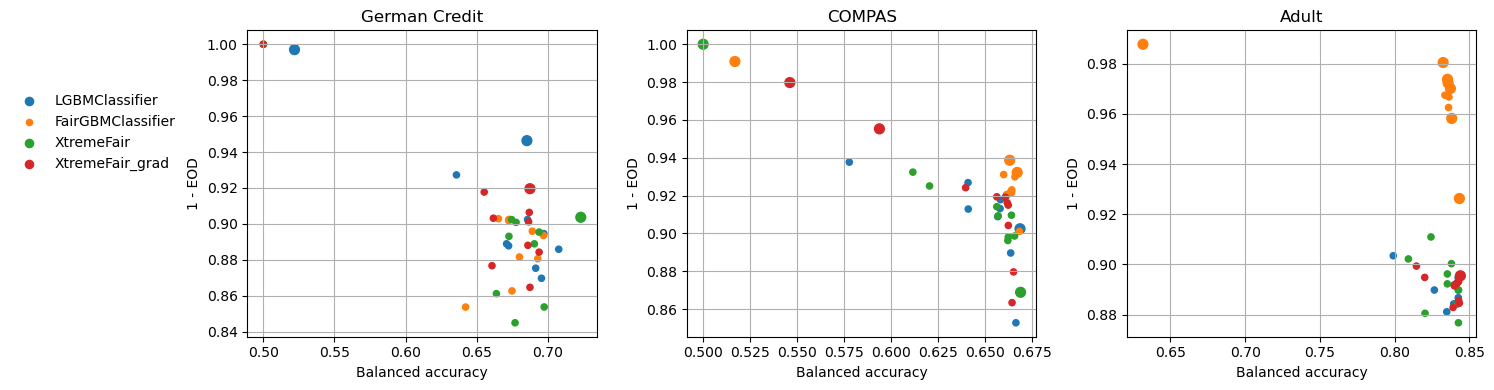

In [4]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "XtremeFair", "XtremeFair_grad"]


for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        if model_name not in selected_models:
            continue
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv").iloc[:, 1:]
        df["model"] = model_name
        df["fair"] = 1 - abs(df["eod"])
        df = df[["model", "bal_acc", "fair"]]
        df = df.groupby("model").mean().reset_index()

        results.append(df)

    results = pd.concat(results).reset_index(drop=True)


    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df = results[results["model"] == model]
        axs[k].scatter(df["bal_acc"], df["fair"], label=model, s=[20 if dominated else 50 for dominated in df["dominated"]],)

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[0].legend(loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

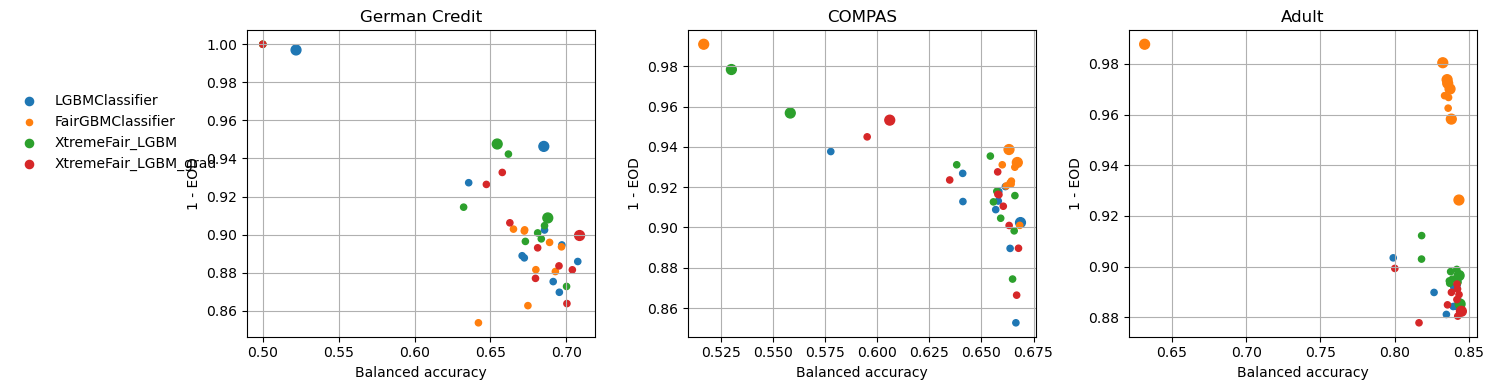

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "XtremeFair_LGBM", "XtremeFair_LGBM_grad"]


for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        if model_name not in selected_models:
            continue
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv").iloc[:, 1:]
        df["model"] = model_name
        df["fair"] = 1 - abs(df["eod"])
        df = df[["model", "bal_acc", "fair"]]
        df = df.groupby("model").mean().reset_index()

        results.append(df)

    results = pd.concat(results).reset_index(drop=True)


    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df = results[results["model"] == model]
        axs[k].scatter(df["bal_acc"], df["fair"], label=model, s=[20 if dominated else 50 for dominated in df["dominated"]],)

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[0].legend(loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

In [10]:
for k, dataset in enumerate(["german", "compas"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*")
    results_mean = []
    results_std = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        if alpha != 0.7:
            continue

        df = pd.read_csv(model + "/results.csv").iloc[:, 1:]
        df["model"] = model_name
        df["fair"] = 1 - abs(df["eod"])
        df = df[["model", "bal_acc", "fair"]]
        df_mean = df.groupby("model").mean().reset_index()
        df_std = df.groupby("model").std().reset_index()

        results_mean.append(df_mean)
        results_std.append(df_std)
    
    results_mean = pd.concat(results_mean).reset_index(drop=True).round(3)
    results_std = pd.concat(results_std).reset_index(drop=True).round(3)

    results_mean["bal_acc"] = results_mean["bal_acc"].astype(str) + " ± " + results_std["bal_acc"].astype(str)
    results_mean["fair"] = results_mean["fair"].astype(str) + " ± " + results_std["fair"].astype(str)

    print(dataset_names[dataset])
    print(results_mean)
    print("\n\n")

    

German Credit
                  model        bal_acc           fair
0        LGBMClassifier  0.708 ± 0.052  0.886 ± 0.078
1            XtremeFair  0.694 ± 0.059  0.895 ± 0.075
2     FairGBMClassifier  0.673 ± 0.064  0.902 ± 0.073
3        FairClassifier  0.701 ± 0.041  0.882 ± 0.091
4       XtremeFair_grad  0.662 ± 0.039  0.903 ± 0.093
5       XtremeFair_LGBM   0.681 ± 0.04  0.901 ± 0.103
6  XtremeFair_LGBM_grad  0.695 ± 0.046  0.884 ± 0.128



COMPAS
                  model        bal_acc           fair
0        LGBMClassifier  0.662 ± 0.013   0.92 ± 0.063
1            XtremeFair  0.662 ± 0.014  0.898 ± 0.067
2     FairGBMClassifier  0.666 ± 0.016   0.93 ± 0.049
3        FairClassifier  0.659 ± 0.014  0.865 ± 0.029
4       XtremeFair_grad  0.662 ± 0.019  0.915 ± 0.045
5       XtremeFair_LGBM  0.657 ± 0.017  0.918 ± 0.063
6  XtremeFair_LGBM_grad  0.661 ± 0.014  0.911 ± 0.065





FileNotFoundError: [Errno 2] No such file or directory: '../results/group_experiment/german/XtremeFair_LGBM_0.7/results_longer.csv'

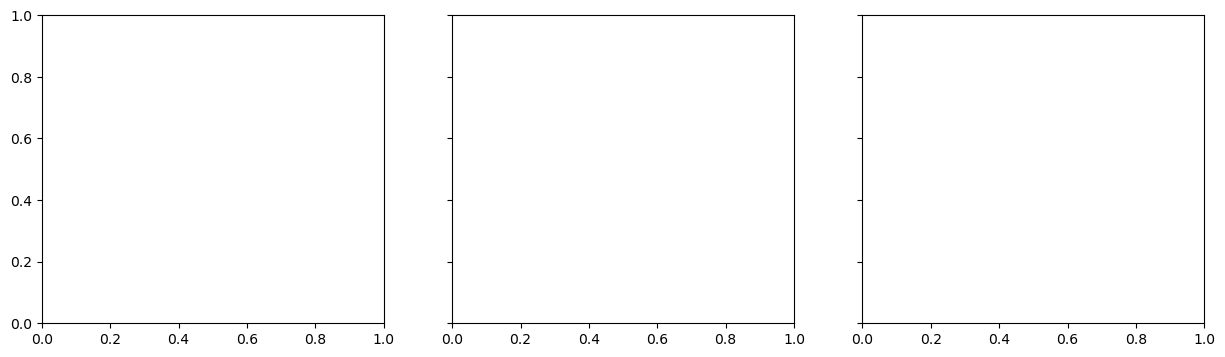

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4), sharey=True)

selected_models = ["LGBMClassifier", "FairGBMClassifier", "XtremeFair_LGBM", "XtremeFair_LGBM_grad"]
for k, dataset in enumerate(["german", "compas"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        if model_name not in selected_models:
            continue
        alpha = float(model.split("_")[-1])
        if alpha != 0.7:
            continue
        df = pd.read_csv(model + "/results_longer.csv").iloc[:, 1:]
        df["model"] = model_name
        df["tpr_min"] = df[["tpr_0", "tpr_1"]].min(axis=1)
        df["tpr_max"] = df[["tpr_0", "tpr_1"]].max(axis=1)
        df = df[["model", "tpr_min", "tpr_max"]]
        df = df.groupby("model").mean().reset_index()

        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_tpr = df["tpr_min"].values[0]
        max_tpr = df["tpr_max"].values[0]
        axs[k].plot([min_tpr, max_tpr], [i, i], label=model, linewidth=2)
        # annotate the difference above the line
        axs[k].annotate(f"EOP = {max_tpr - min_tpr:.3f}", (min_tpr, i - 0.15), fontsize=9)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Min-Max TPR")
    axs[k].set_ylim(-0.5, 3.5)
    axs[k].set_yticks([0, 1, 2, 3])
    axs[k].set_yticklabels(["LGBM", "FairGBM", "XtremeFair", "XtremeFair_grad"])
    #if k == 0:
    #    axs[0].legend(loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

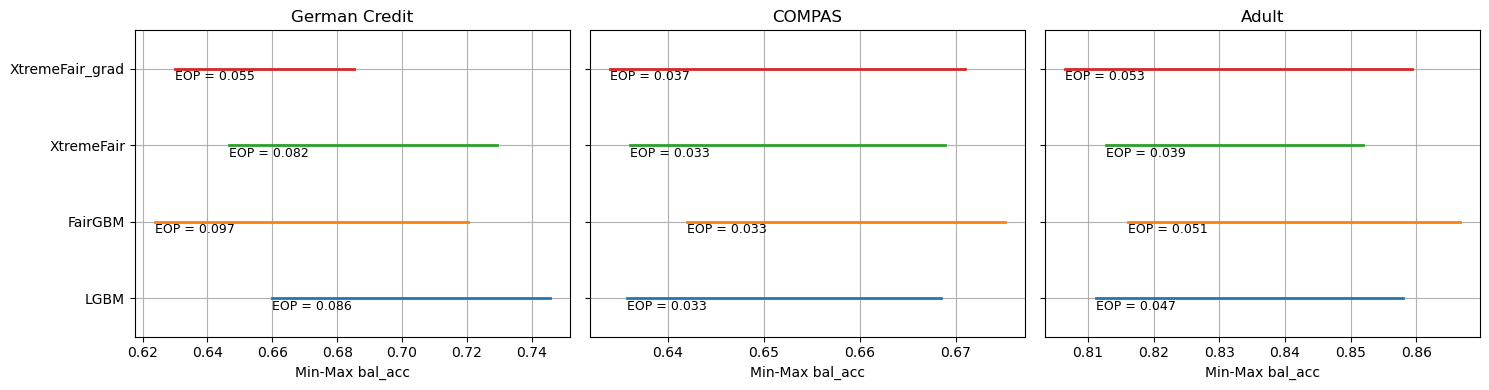

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4), sharey=True)

for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = glob.glob(f"../results/group_experiment/{dataset}/*")
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        if model_name not in ["LGBMClassifier", "FairGBMClassifier", "XtremeFair", "XtremeFair_grad"]:
            continue
        alpha = float(model.split("_")[-1])
        if alpha != 0.7:
            continue
        df = pd.read_csv(model + "/results_longer.csv").iloc[:, 1:]
        df["model"] = model_name
        df["bal_acc_min"] = df[["bal_acc_0", "bal_acc_1"]].min(axis=1)
        df["bal_acc_max"] = df[["bal_acc_0", "bal_acc_1"]].max(axis=1)
        df = df[["model", "bal_acc_min", "bal_acc_max"]]
        df = df.groupby("model").mean().reset_index()

        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(["LGBMClassifier", "FairGBMClassifier", "XtremeFair", "XtremeFair_grad"]):
        df = results[results["model"] == model]
        min_bal_acc = df["bal_acc_min"].values[0]
        max_bal_acc = df["bal_acc_max"].values[0]
        axs[k].plot([min_bal_acc, max_bal_acc], [i, i], label=model, linewidth=2)
        # annotate the difference above the line
        axs[k].annotate(f"EOP = {max_bal_acc - min_bal_acc:.3f}", (min_bal_acc, i - 0.15), fontsize=9)
        

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Min-Max bal_acc")
    axs[k].set_ylim(-0.5, 3.5)
    axs[k].set_yticks([0, 1, 2, 3])
    axs[k].set_yticklabels(["LGBM", "FairGBM", "XtremeFair", "XtremeFair_grad"])
    #if k == 0:
    #    axs[0].legend(loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()